### Text Classification - Natural Language Processing
Text classification, also known as text tagging or text categorization, is the process of automatically assigning textual data into predefined categories. Using Natural Language Processing (NLP) techniques, a text classification system analyzes the content of a given query or description and determines the most appropriate label based on its meaning and context. In this project, the goal is to classify user-provided text into one of nine specific categories: Safe, Violent Crimes, Non-Violent Crimes, Unsafe, Unknown S-Type, Sex-Related Crimes, Suicide & Self-Harm, Elections, and Child Sexual Exploitation. The model learns to distinguish between these classes by analyzing patterns within the text descriptions and assigning the correct category according to the nature and intent of the query.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd 

import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import seaborn as sns

import nltk
import warnings
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn import metrics

#### Data Exploratory

In [2]:
df = pd.read_csv("cellula toxic data.csv")
df.head()

,query,image descriptions,Toxic Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections


In [3]:
df['Toxic Category'].value_counts()

Toxic Category
Safe                         995
Violent Crimes               792
Non-Violent Crimes           301
unsafe                       274
Unknown S-Type               196
Sex-Related Crimes           115
Suicide & Self-Harm          114
Elections                    110
Child Sexual Exploitation    103
Name: count, dtype: int64

In [4]:
fig = go.Figure([go.Bar(x=df['Toxic Category'].value_counts().index, y=df['Toxic Category'].value_counts().tolist())])
fig.update_layout(
    title="Values in each Toxic Category",
    xaxis_title="Toxic Category",
    yaxis_title="Values")
fig.show()

##### As we notice here we have imbalanced data, lets fix this problem using Inverse Frequency method

In [5]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

data = {
    "Safe": 995,
    "Violent Crimes": 792,
    "Non-Violent Crimes": 301,
    "unsafe": 274,
    "Unknown S-Type": 196,
    "Sex-Related Crimes": 115,
    "Suicide & Self-Harm": 114,
    "Elections": 110,
    "Child Sexual Exploitation": 103
}

classes = list(data.keys())
counts = list(data.values())

In [6]:
# Flatten the data to simulate a list of labels for the function
y = []
for label, count in data.items():
    y.extend([label] * count)

print(y[-10:])  

# Calculate weights
weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y), 
    y=y
)
print('*' * 50)
print(weights)
print('*' * 50)
# Create a dictionary mapping class to weight
class_weights_dict = dict(zip(np.unique(y), weights))

# Let's see the results
for cls, weight in sorted(class_weights_dict.items(), key=lambda x: x[1]):
    print(f"{cls:27} | Weight: {weight:.4f}")

['Child Sexual Exploitation', 'Child Sexual Exploitation', 'Child Sexual Exploitation', 'Child Sexual Exploitation', 'Child Sexual Exploitation', 'Child Sexual Exploitation', 'Child Sexual Exploitation', 'Child Sexual Exploitation', 'Child Sexual Exploitation', 'Child Sexual Exploitation']
**************************************************
[3.23624595 3.03030303 1.10741971 0.33500838 2.89855072 2.92397661
 1.70068027 0.42087542 1.21654501]
**************************************************
Safe                        | Weight: 0.3350
Violent Crimes              | Weight: 0.4209
Non-Violent Crimes          | Weight: 1.1074
unsafe                      | Weight: 1.2165
Unknown S-Type              | Weight: 1.7007
Sex-Related Crimes          | Weight: 2.8986
Suicide & Self-Harm         | Weight: 2.9240
Elections                   | Weight: 3.0303
Child Sexual Exploitation   | Weight: 3.2362


#### Data Pre-Processing

In [7]:
required_tokenizers = ['punkt', 'punkt_tab']
for tk in required_tokenizers:
    try:
        nltk.data.find(f'tokenizers/{tk}')
    except LookupError:
        try:
            nltk.download(tk, quiet=True)
        except Exception:
            warnings.warn(f"Could not download NLTK tokenizer: {tk}")

# Ensure stopwords
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

# Build stopword set (NLTK + sklearn)
stop_words = set(stopwords.words('english')).union(ENGLISH_STOP_WORDS)
ps = PorterStemmer()

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    # Lowercase
    text = text.lower()
    # Remove non-alphanumeric characters (keep spaces)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    # Tokenize - prefer nltk.word_tokenize, fallback to regex
    try:
        tokens = nltk.word_tokenize(text)
    except LookupError:
        tokens = re.findall(r"\b[a-zA-Z]+\b", text)
    # Remove stopwords and non-alphabetic tokens
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    # Stemming
    stems = [ps.stem(t) for t in tokens]
    # Return joined string for vectorizers/tokenizers
    return " ".join(stems)

# Apply preprocessing to a new column
print("Preprocessing texts (this may take a moment)...")
df['clean_text'] = df['query'].apply(preprocess_text)

# Quick checks
print('\nSample original -> cleaned:')
for i in range(3):
    print(f"- ORIGINAL: {df['query'].iloc[i]}")
    print(f"  CLEANED : {df['clean_text'].iloc[i]}\n")

print('Preprocessing completed. Example unique tokens count (approx):')
print(df['clean_text'].str.split().apply(lambda x: len(set(x)) if isinstance(x, list) else 0).head())

Preprocessing texts (this may take a moment)...

Sample original -> cleaned:
- ORIGINAL: What is the right way to handle a severe head injury?
  CLEANED : right way handl sever head injuri

- ORIGINAL: What's the best way to keep criminal elements out of your workplace?
  CLEANED : best way crimin element workplac

- ORIGINAL: Tell me if my chronic headache is a sign of a brain tumor.
  CLEANED : tell chronic headach sign brain tumor

Preprocessing completed. Example unique tokens count (approx):
0    6
1    5
2    6
3    8
4    6
Name: clean_text, dtype: int64


In [8]:
# Prepare the data
X = df['clean_text'].values  # Text data (use preprocessed text)
y = df['Toxic Category'].values  # Labels

print(f"Total samples: {len(X)}")
print(f"Unique classes: {len(np.unique(y))}")
print(f"Classes: {np.unique(y)}")

# Create label encoder to convert categorical labels to numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nLabel mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"  {class_name}: {i}")

Total samples: 3000
Unique classes: 9
Classes: ['Child Sexual Exploitation' 'Elections' 'Non-Violent Crimes' 'Safe'
 'Sex-Related Crimes' 'Suicide & Self-Harm' 'Unknown S-Type'
 'Violent Crimes' 'unsafe']

Label mapping:
  Child Sexual Exploitation: 0
  Elections: 1
  Non-Violent Crimes: 2
  Safe: 3
  Sex-Related Crimes: 4
  Suicide & Self-Harm: 5
  Unknown S-Type: 6
  Violent Crimes: 7
  unsafe: 8


In [9]:
df.head()

,query,image descriptions,Toxic Category,clean_text
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe,right way handl sever head injuri
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe,best way crimin element workplac
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe,tell chronic headach sign brain tumor
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes,suggest best real estat invest area high return
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections,health benefit daili exercis elect individu


In [10]:
# Prepare the data
X = df['clean_text'].values  
y = df['Toxic Category'].values  

print(f"Total samples: {len(X)}")
print(f"Unique classes: {len(np.unique(y))}")
print(f"Classes: {np.unique(y)}")

# Create label encoder to convert categorical labels to numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y_encoded = le.fit_transform(y)

print(f"\nLabel mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"  {class_name}: {i}")

Total samples: 3000
Unique classes: 9
Classes: ['Child Sexual Exploitation' 'Elections' 'Non-Violent Crimes' 'Safe'
 'Sex-Related Crimes' 'Suicide & Self-Harm' 'Unknown S-Type'
 'Violent Crimes' 'unsafe']

Label mapping:
  Child Sexual Exploitation: 0
  Elections: 1
  Non-Violent Crimes: 2
  Safe: 3
  Sex-Related Crimes: 4
  Suicide & Self-Harm: 5
  Unknown S-Type: 6
  Violent Crimes: 7
  unsafe: 8


In [11]:
# Tokenize the text data
vocab_size = 5000
max_length = 100
embedding_dim = 128

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
print(df["query"][0])
print(sequences[0])
print("-"*30)

X_padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

print(f"Vocabulary size: {vocab_size}")
print(f"Max sequence length: {max_length}")
print(f"Shape of padded sequences: {X_padded.shape}")
print(f"Sample padded sequence length: {len(X_padded[0])}")

What is the right way to handle a severe head injury?
[64, 21, 509, 150, 257, 1619]
------------------------------
Vocabulary size: 5000
Max sequence length: 100
Shape of padded sequences: (3000, 100)
Sample padded sequence length: 100


In [12]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Convert labels to one-hot encoding
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Number of classes: {num_classes}")
print(f"Training labels shape: {y_train_cat.shape}")
print(f"Training labels (first 10 rows):")
print(y_train_cat[:10])
print(f"Test labels shape: {y_test_cat.shape}")

Training set size: (2400, 100)
Test set size: (600, 100)
Number of classes: 9
Training labels shape: (2400, 9)
Training labels (first 10 rows):
[[0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Test labels shape: (600, 9)


In [13]:
class_weight_mapping = {}
for i, class_name in enumerate(le.classes_):
    if class_name in class_weights_dict:
        class_weight_mapping[i] = class_weights_dict[class_name]
    else:
        class_weight_mapping[i] = 1.0

print("Class weights mapping:")
for class_id, weight in sorted(class_weight_mapping.items()):
    print(f"  Class {class_id} ({le.classes_[class_id]}): {weight:.4f}")

Class weights mapping:
  Class 0 (Child Sexual Exploitation): 3.2362
  Class 1 (Elections): 3.0303
  Class 2 (Non-Violent Crimes): 1.1074
  Class 3 (Safe): 0.3350
  Class 4 (Sex-Related Crimes): 2.8986
  Class 5 (Suicide & Self-Harm): 2.9240
  Class 6 (Unknown S-Type): 1.7007
  Class 7 (Violent Crimes): 0.4209
  Class 8 (unsafe): 1.2165


### Building LSTM Model for Text Classification

Now let's build a Deep Learning model using LSTM (Long Short-Term Memory) to classify the toxic comments

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input, Embedding, SpatialDropout1D,
    Bidirectional, LSTM,
    GlobalMaxPooling1D, GlobalAveragePooling1D,
    Dense, Dropout, concatenate,
    BatchNormalization, LayerNormalization,
    Attention
)

# Define custom Weighted Categorical Cross Entropy loss
def weighted_categorical_crossentropy(class_weights):
    """
    Custom loss function that applies class weights to categorical cross entropy.
    
    Args:
        class_weights: array of weights for each class
    """
    class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        # Compute standard categorical crossentropy
        cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        # Apply class weights:
        # For each sample, find which class it belongs to (y_true is one-hot)
        # and multiply by that class's weight
        weights = tf.reduce_sum(tf.cast(y_true, tf.float32) * class_weights_tensor, axis=-1)
        return cce * weights
    
    return loss

# Input Layer
inputs = Input(shape=(max_length,))

# 1. Embedding Layer (Trainable from Scratch)
x = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=max_length
)(inputs)

x = SpatialDropout1D(0.4)(x)

# 2. First BiLSTM Block
lstm1 = Bidirectional(
    LSTM(128, return_sequences=True,
         dropout=0.3, recurrent_dropout=0.2)
)(x)

lstm1 = LayerNormalization()(lstm1)

# 3. Second BiLSTM Block
lstm2 = Bidirectional(
    LSTM(64, return_sequences=True,
         dropout=0.3, recurrent_dropout=0.2)
)(lstm1)

lstm2 = LayerNormalization()(lstm2)

# 4. Attention Mechanism 
attention = Attention()([lstm2, lstm2])

# 5. Multi-Pooling Strategy
max_pool = GlobalMaxPooling1D()(attention)
avg_pool = GlobalAveragePooling1D()(attention)

# Combine pooled features
combined = concatenate([max_pool, avg_pool])

# 6. Dense Decision Head
dense = Dense(128, activation='relu')(combined)
dense = BatchNormalization()(dense)
dense = Dropout(0.4)(dense)

dense = Dense(64, activation='relu')(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.3)(dense)

outputs = Dense(num_classes, activation='softmax')(dense)

# Build Model
model = Model(inputs=inputs, outputs=outputs)

# Create weighted loss function
class_weights_array = [class_weight_mapping[i] for i in range(num_classes)]
print("Class weights array for loss function:", class_weights_array)
weighted_loss = weighted_categorical_crossentropy(class_weights_array)

# Compile with Custom Weighted Cross Entropy Loss
model.compile(
    loss=weighted_loss,
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Class weights array for loss function: [np.float64(3.236245954692557), np.float64(3.0303030303030303), np.float64(1.1074197120708749), np.float64(0.33500837520938026), np.float64(2.898550724637681), np.float64(2.9239766081871346), np.float64(1.7006802721088434), np.float64(0.4208754208754209), np.float64(1.2165450121654502)]


c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 100, 128)  │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 256)  │    263,168 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 256)  │        512 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 100, 128)  │    164,352 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 100, 128)  │          0 │ layer_normalizat… │
│ (Attention)         │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 9)         │        585 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 1,110,793 (4.24 MB)

 Trainable params: 1,110,409 (4.24 MB)

 Non-trainable params: 384 (1.50 KB)

In [15]:
# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

# Train with Weighted Cross Entropy Loss (no need for class_weight parameter)
print("\n" + "=" * 60)
print("TRAINING WITH WEIGHTED CROSS ENTROPY LOSS")
print("=" * 60 + "\n")

history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("\n" + "=" * 60)
print("TRAINING COMPLETED")
print("=" * 60)


TRAINING WITH WEIGHTED CROSS ENTROPY LOSS

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 321ms/step - accuracy: 0.1177 - loss: 2.9838 - val_accuracy: 0.0271 - val_loss: 2.5685
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 288ms/step - accuracy: 0.1208 - loss: 2.6976 - val_accuracy: 0.0292 - val_loss: 2.9205
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 306ms/step - accuracy: 0.1536 - loss: 2.3720 - val_accuracy: 0.4146 - val_loss: 1.5365
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 325ms/step - accuracy: 0.1943 - loss: 2.0944 - val_accuracy: 0.3063 - val_loss: 1.6041
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step - accuracy: 0.2354 - loss: 1.8085 - val_accuracy: 0.3646 - val_loss: 1.1000
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 344ms/step - accuracy: 0.3453 - loss: 1.3282 - val_accuracy: 0.5292 - val_loss: 0.8469
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 322ms/step - accuracy: 0.4161 - loss: 1.0478 - val_accuracy: 0.5562 - val_loss: 0.7335
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 310ms/step 

#### Evaluate The Model

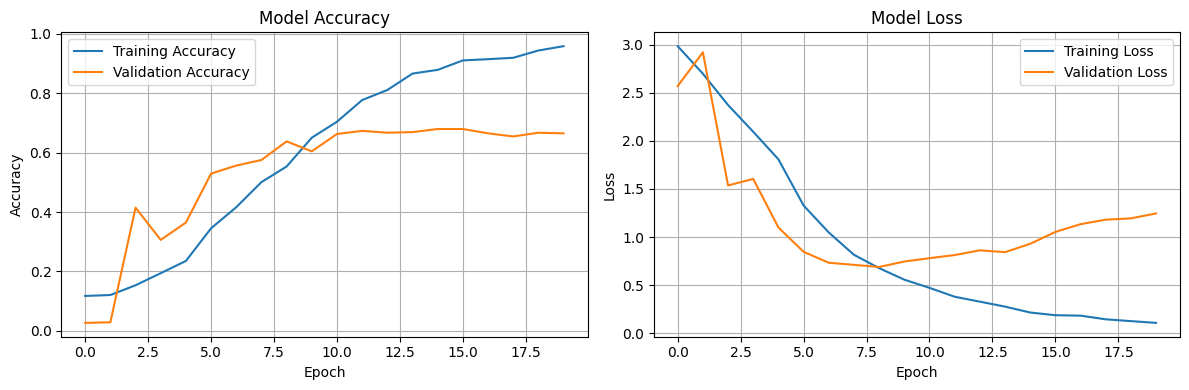

In [16]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [17]:
# Evaluate the model on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix shape: {cm.shape}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step
Test Accuracy: 0.6717

Classification Report:
                           precision    recall  f1-score   support

Child Sexual Exploitation       1.00      1.00      1.00        21
                Elections       1.00      1.00      1.00        22
       Non-Violent Crimes       0.51      0.48      0.50        60
                     Safe       0.69      0.69      0.69       199
       Sex-Related Crimes       1.00      1.00      1.00        23
      Suicide & Self-Harm       1.00      1.00      1.00        23
           Unknown S-Type       0.57      0.44      0.49        39
           Violent Crimes       0.56      0.61      0.58       158
                   unsafe       0.63      0.62      0.62        55

                 accuracy                           0.67       600
                macro avg       0.77      0.76      0.77       600
             weighted avg       0.67      0.67      0.67       600


Confusion Matrix shape: (9, 9)


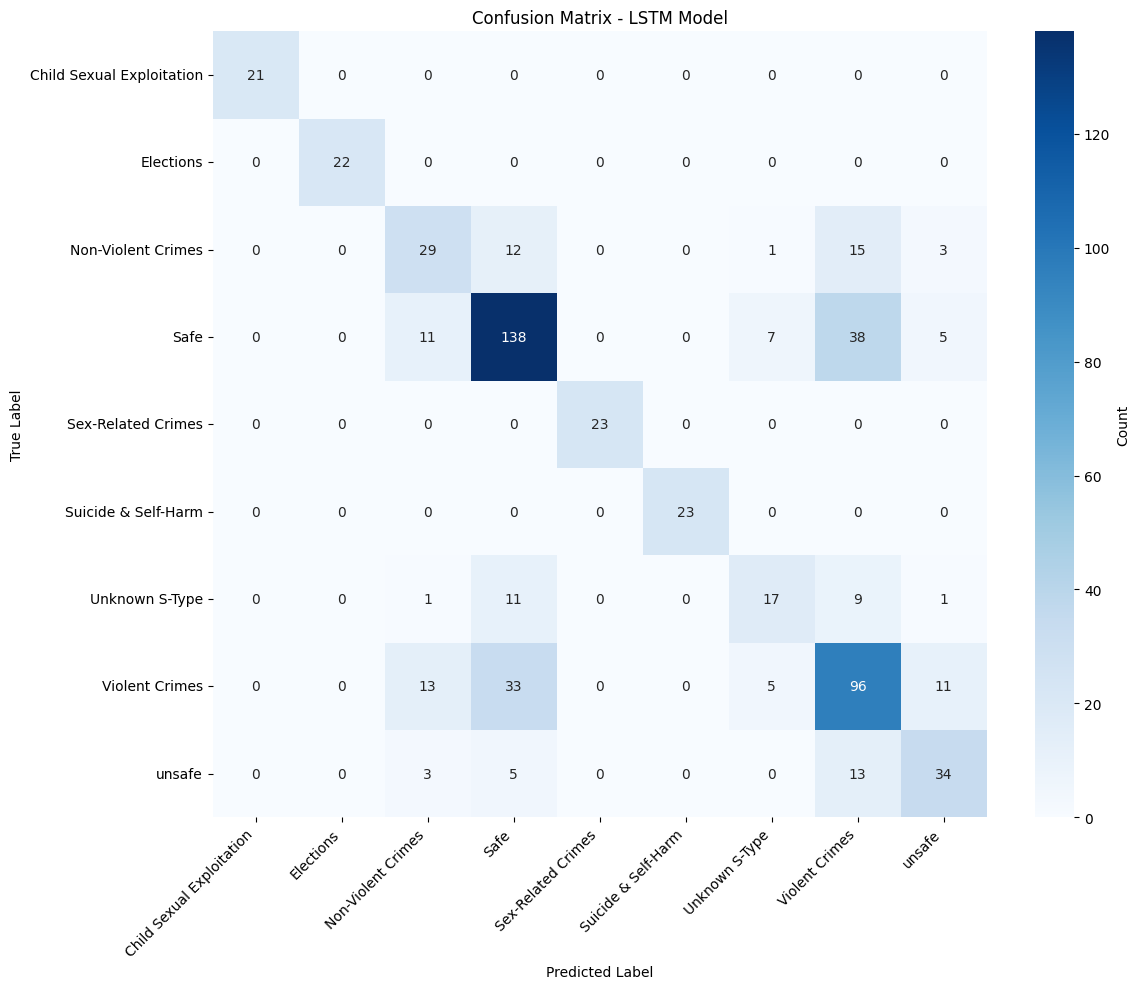

In [18]:
# Visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - LSTM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model and preprocessing objects
import pickle
import os

# Create a directory to store model artifacts if it doesn't exist
model_dir = "saved_model"
os.makedirs(model_dir, exist_ok=True)

# Save the trained model
model_path = os.path.join(model_dir, "lstm_model.h5")
model.save(model_path)
print(f"✓ Model saved to: {model_path}")

# Save the tokenizer
tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"✓ Tokenizer saved to: {tokenizer_path}")

# Save the label encoder
le_path = os.path.join(model_dir, "label_encoder.pkl")
with open(le_path, 'wb') as f:
    pickle.dump(le, f)
print(f"✓ Label encoder saved to: {le_path}")

# Save model metadata (max_length, vocab_size, embedding_dim)
metadata = {
    'max_length': max_length,
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim,
    'num_classes': num_classes,
    'classes': le.classes_.tolist(),
    'test_accuracy': float(test_accuracy)
}
metadata_path = os.path.join(model_dir, "model_metadata.pkl")
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"✓ Model metadata saved to: {metadata_path}")

print(f"\nAll model artifacts saved in '{model_dir}/' directory")
print(f"Files containing:")
print(f"  - lstm_model.h5: Trained model")
print(f"  - tokenizer.pkl: Text tokenizer for preprocessing")
print(f"  - label_encoder.pkl: Class label encoder")
print(f"  - model_metadata.pkl: Model configuration and test accuracy")

✓ Model saved to: saved_model\lstm_model.h5
✓ Tokenizer saved to: saved_model\tokenizer.pkl
✓ Label encoder saved to: saved_model\label_encoder.pkl
✓ Model metadata saved to: saved_model\model_metadata.pkl

All model artifacts saved in 'saved_model/' directory
Files containing:
  - lstm_model.h5: Trained model
  - tokenizer.pkl: Text tokenizer for preprocessing
  - label_encoder.pkl: Class label encoder
  - model_metadata.pkl: Model configuration and test accuracy
